# EVALUATION OF EXPERIMENTS

### Imports

In [2]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"

project_root = os.path.abspath("..")  # If notebooks is one folder above src
if project_root not in sys.path:
    sys.path.insert(0, project_root)
# Get the parent directory (one level above)
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)
sys.path.insert(0,parent_dir + "/socmatching")

import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch_optimizer as torch_optim

from torch.utils.data import Dataset, DataLoader
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, TensorDataset, DistributedSampler
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import math
from omegaconf import OmegaConf
import yaml
import time

import wandb

from socmatching.SOC_matching.utils import (
    get_folder_name,
    get_file_name,
    control_objective,
    save_results,
    compute_EMA,
    normalization_constant,
    stochastic_trajectories
)

from socmatching.SOC_matching.method import (
    SOC_Solver,
)

from src.soc.settings import get_energy, get_Rfunc
from src.soc.utils import exact_eigfunctions

from src.soc.method import EigenSolver, CombinedSDE

from src.experiment_settings.socm_settings.settings import define_variables as define_variables_socm
from src.experiment_settings.efc_settings.settings import define_variables as define_variables_efc


### Setup

In [90]:
experiment_path = "experiments/OUQ_hard_T4_d20_repulsive"

In [91]:
cfg = OmegaConf.load(experiment_path+f'/EFC_2/cfg.yaml')
torch.manual_seed(cfg.method.seed)
ts = torch.linspace(0, cfg.method.T, cfg.method.num_steps + 1).to(cfg.method.device)

x0, sigma, optimal_sde, neural_sde = define_variables_efc(cfg, ts)

x0: tensor([-0.5629, -0.5762, -0.1253, -0.2169,  0.2994, -0.7775, -0.1707,  0.9265,
         0.2340, -0.0789,  0.7218,  0.1330,  0.6947,  0.7932,  0.4731, -0.4218,
         0.4659,  0.6295,  1.0025,  0.0269], device='cuda:0')
2


In [92]:
#x0, sigma, optimal_sde, neural_sde = define_variables_efc(cfg, ts)
if optimal_sde is not None:
    ground_truth_control = optimal_sde.u
else:
    ground_truth_control = None
    
batch_size = 128*32
state0 = x0.repeat(batch_size, 1) * 2

neural_sde.use_learned_control = False
neural_sde.u = ground_truth_control
states,_,_,_,_,_,_,_, = stochastic_trajectories(
                        neural_sde,
                        state0,
                        ts.to(state0),
                        cfg.method.lmbd,
                        detach=True
                        )

neural_sde.use_learned_control = True

target_control = ground_truth_control(ts, states, t_is_tensor=True)

Defining solver

In [ ]:
def get_err(experiment_name, itr):
    cfg = OmegaConf.load(experiment_path+f'/{experiment_name}/cfg.yaml')

    if experiment_name[:3] == "EFC":
        x0, sigma, optimal_sde, neural_sde = define_variables_efc(cfg, ts)
        print(neural_sde.joint)
        solver = EigenSolver(
                neural_sde,
                x0,
                ground_truth_control,
                T=cfg.method.T,
                num_steps=cfg.method.num_steps,
                lmbd=cfg.method.lmbd,
                d=cfg.method.d,
                sigma=sigma,
                langevin_burnin_steps=cfg.method.langevin_burnin_steps,
                langevin_sample_steps=cfg.method.langevin_sample_steps,
                langevin_dt=cfg.method.langevin_dt
            )
        # if solver.neural_sde.k == 2:
        #     solver.neural_sde.inner_prods = torch.tensor([0.03, 0.002],device='cuda')
        #     solver.neural_sde.eigvals = torch.tensor([0, 18.33-14.58],device='cuda')
        #     solver.neural_sde.norms = (1-cfg.loss.beta*solver.neural_sde.eigvals/2).sqrt()
    else:
        x0, sigma, optimal_sde, neural_sde, u_warm_start = define_variables_socm(cfg, ts)

        solver = SOC_Solver(
            neural_sde,
            x0,
            ground_truth_control,
            T=cfg.method.train_T,
            num_steps=cfg.method.train_steps,
            lmbd=cfg.method.lmbd,
            d=cfg.method.d,
            sigma=sigma,
        )

    solver.load_state_dict(torch.load(experiment_path + f'/{experiment_name}/solver_weights_{itr:_}.pth'))
    
    if experiment_name[:3] == "EFC":
        learned_control = neural_sde.control(ts,states,1,1e-2)
    else:
        ts_input = torch.maximum(ts - cfg.method.T + cfg.method.train_T, torch.ones(1,device=ts.device)*0)
        learned_control = neural_sde.control(ts_input,states)

    err = (torch.sum((target_control - learned_control) ** 2, dim=-1)).detach().cpu()

    return err

x0: tensor([ 0.3227, -0.4247, -0.4524,  0.0307, -0.2373, -0.5507,  0.0701,  0.2041,
         0.4132,  0.5860,  0.5605, -0.3774,  0.0343,  0.4713,  0.9009, -0.3816,
        -1.0243, -0.2413, -0.1597,  0.3849], device='cuda:0')
2
False


/tmp/ipykernel_387186/3814499714.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  solver.load_state_dict(torch.load(experiment_path + f'/{experiment_name}/solver_weights

x0: tensor([-0.2826, -0.5856, -0.1249, -0.0782,  0.4541,  0.0764, -0.2721, -0.3139,
        -0.3570,  0.7294,  0.4293,  0.1977, -0.0310,  0.2749, -0.4342,  0.4057,
        -0.1826,  0.4894, -1.1775, -0.2156], device='cuda:0')
initialize_models, self.use_stopping_time: False
x0: tensor([ 0.0325, -0.1184,  1.1670,  0.0108,  0.0666, -0.3730,  0.5493, -0.0305,
        -0.6895, -1.1080,  0.8876, -0.1327, -0.1651,  0.1715,  0.7859, -0.1098,
         0.6502,  0.9160,  0.3583, -0.7545], device='cuda:0')
initialize_models, self.use_stopping_time: False
x0: tensor([-6.5245e-03, -3.3251e-01, -7.3501e-02,  7.5203e-02,  8.3626e-01,
         6.3897e-01, -4.6448e-01, -2.6882e-01,  4.6850e-04, -1.1793e+00,
        -3.8752e-02, -9.7919e-01,  6.1074e-01, -3.6746e-01, -3.2804e-01,
         3.4079e-01,  6.9935e-01,  3.4431e-01,  2.5464e-01,  9.6847e-01],
       device='cuda:0')
initialize_models, self.use_stopping_time: False


Text(0, 0.5, '$L^2$ error')

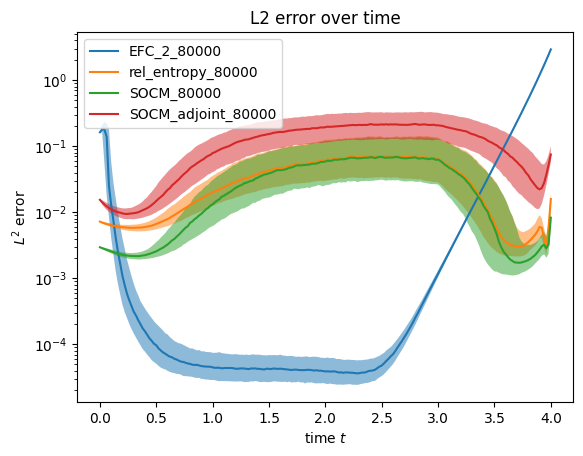

In [94]:
experiments = ['EFC_2','rel_entropy','SOCM','SOCM_adjoint']
itrs = [80000,80000,80000,80000]

err_dict = {}
keys = [f'{experiments[i]}_{itrs[i]}' for i in range(len(experiments))] 

for i in range(len(experiments)):
    err_dict[keys[i]] = get_err(experiments[i],itrs[i])

for experiment, err in err_dict.items():
    plt.plot(ts.cpu(), err.median(dim=1).values, label = experiment)
    plt.fill_between(ts.cpu(),
                err.quantile(0.25,dim=1),
                err.quantile(0.75,dim=1),alpha=0.5)
plt.yscale('log')
plt.legend()
plt.title('L2 error over time')
plt.xlabel('time $t$')
plt.ylabel('$L^2$ error')
#plt.xlim(3,4)

In [7]:
num = 16
experiments = ['SOCM'] * num
itrs = 5000 * np.arange(1,num+1)

err_dict = {}
keys = [f'{experiments[i]}_{itrs[i]}' for i in range(len(experiments))] 

for i in range(len(experiments)):
    err_dict[keys[i]] = get_err(experiments[i],itrs[i])

x0: tensor([-0.8538, -0.4522,  0.1153, -0.4591,  0.2719,  0.4227, -0.2493, -0.4744,
        -0.0912,  0.2190, -0.4412, -0.0846,  0.9312,  0.8948, -0.0134, -0.7650,
        -0.5245, -0.1166,  0.1711,  0.3488], device='cuda:0')
initialize_models, self.use_stopping_time: False
x0: tensor([-0.3241,  0.3112,  0.0419, -0.3462, -0.0132, -0.5350, -0.8339, -0.7116,
         0.0425, -0.9643, -0.4972,  0.3344, -1.1810, -0.5543, -0.2172,  0.3143,
         0.4779, -0.1531,  0.5526, -0.3731], device='cuda:0')
initialize_models, self.use_stopping_time: False
x0: tensor([-0.0920,  0.3165,  0.4320,  0.0128,  1.0759,  0.4156,  0.3072,  0.4776,
         0.2414,  0.0109, -0.9165, -0.1430, -0.0405,  0.0484, -0.2097, -0.2737,
        -0.1979, -0.6628,  0.1377, -0.0448], device='cuda:0')
initialize_models, self.use_stopping_time: False
x0: tensor([-0.1775,  0.3794, -0.0096,  0.7463,  0.2983,  0.2742, -0.0608, -0.4976,
         0.7323, -0.0643,  0.3184,  0.1997,  0.1444,  0.0966, -0.6746, -1.2639,
        -0.

/tmp/ipykernel_269060/436930208.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  solver.load_state_dict(torch.load(experiment_path + f'/{experiment_name}/solver_weights_

x0: tensor([-0.3642,  1.0072, -0.5567, -0.2623, -0.6679, -0.3328, -0.3054, -0.3484,
         0.0253,  0.3635,  0.4464,  0.2475,  0.4491, -0.8113, -0.6979, -0.0413,
         0.9755, -0.1136, -0.2351, -0.2266], device='cuda:0')
initialize_models, self.use_stopping_time: False
x0: tensor([-4.4674e-01, -9.2091e-04, -3.0647e-01,  3.6575e-01,  1.9129e-01,
         3.1017e-01,  4.2459e-01,  6.0926e-02,  2.4461e-02,  1.1574e+00,
         1.3613e+00, -8.8089e-02,  5.8852e-01,  6.1260e-01, -2.6478e-01,
        -1.4024e-01,  1.6661e-01,  4.2550e-01, -6.0963e-01,  1.7838e-01],
       device='cuda:0')
initialize_models, self.use_stopping_time: False
x0: tensor([-0.2565, -0.3659,  0.1591,  0.4291, -0.5012, -0.0567, -0.8188, -0.9057,
        -0.6758,  0.5190, -0.0104,  0.1717, -0.1717, -0.2730,  0.4415,  0.2735,
         0.8241, -0.6315,  0.0296,  0.1318], device='cuda:0')
initialize_models, self.use_stopping_time: False
x0: tensor([-0.0495, -0.2669,  0.0279,  0.1581,  0.3244,  0.4432, -0.2973,  0.23

Text(0, 0.5, '$L^2$ error')

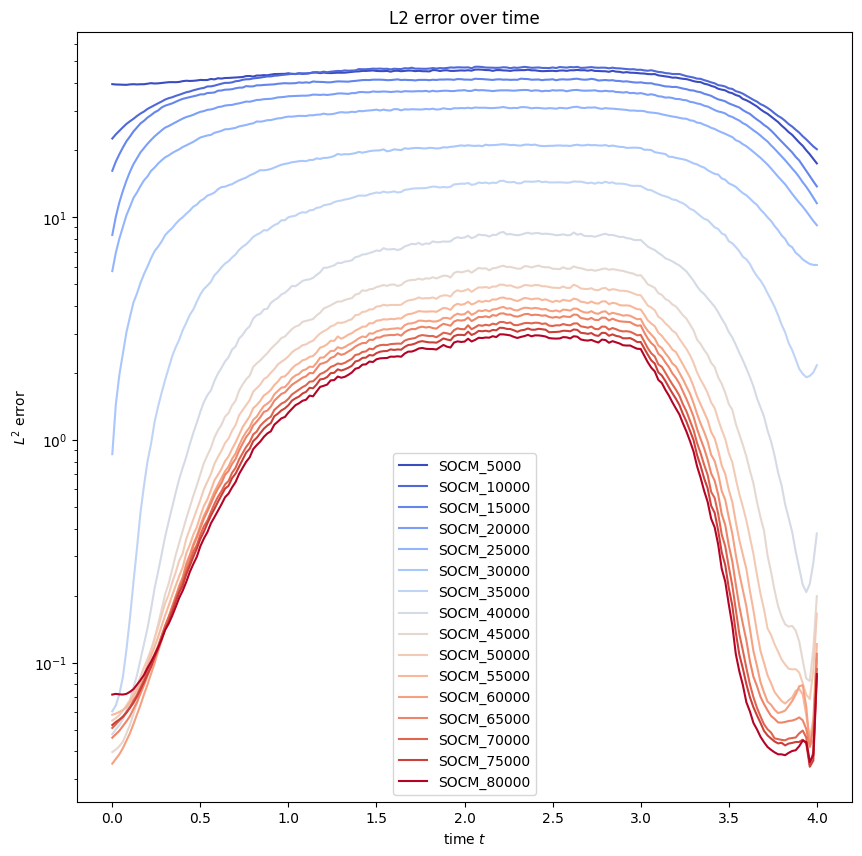

In [8]:
colormap_name = 'coolwarm'
colormap = plt.get_cmap(colormap_name)

colors = {keys[i]: colormap(i / (len(err_dict) - 1)) for i in range(len(err_dict))}

fig, ax = plt.subplots(1,1,figsize=(10,10))

for experiment, err in err_dict.items():
    ax.plot(ts.cpu(), err.median(dim=1).values, label = experiment, color = colors[experiment])
    # plt.fill_between(ts.cpu(),
    #             err.quantile(0.25,dim=1),
    #             err.quantile(0.75,dim=1),alpha=0.5)
ax.set_yscale('log')
ax.legend()
ax.set_title('L2 error over time')
ax.set_xlabel('time $t$')
ax.set_ylabel('$L^2$ error')

#### IC Sensitivity

SOCM

In [63]:
itr = 80000

socm_cfg = OmegaConf.load(experiment_path+f'/SOCM/cfg.yaml')
efc_cfg = OmegaConf.load(experiment_path+f'/EFC_2/cfg.yaml')

cfg = socm_cfg
x0, sigma, optimal_sde, neural_sde, u_warm_start = define_variables_socm(cfg, ts)

socm_solver = SOC_Solver(
    neural_sde,
    x0,
    ground_truth_control,
    T=cfg.method.train_T,
    num_steps=cfg.method.train_steps,
    lmbd=cfg.method.lmbd,
    d=cfg.method.d,
    sigma=sigma,
)

cfg = efc_cfg
x0, sigma, optimal_sde, neural_sde = define_variables_efc(cfg, ts)

efc_solver = EigenSolver(
    neural_sde,
    x0,
    ground_truth_control,
    T=cfg.method.T,
    num_steps=cfg.method.num_steps,
    lmbd=cfg.method.lmbd,
    d=cfg.method.d,
    sigma=sigma,
    langevin_burnin_steps=cfg.method.langevin_burnin_steps,
    langevin_sample_steps=cfg.method.langevin_sample_steps,
    langevin_dt=cfg.method.langevin_dt
)

socm_solver.load_state_dict(torch.load(experiment_path + f'/SOCM/solver_weights_{itr:_}.pth'))
efc_solver.load_state_dict(torch.load(experiment_path + f'/EFC_2/solver_weights_{itr:_}.pth'))

x0: tensor([-0.5396,  0.2599,  0.2369, -0.4529, -0.6044,  0.4957, -0.0795,  1.0857,
        -0.8476,  0.4146, -0.8507, -0.1332, -0.0081,  0.7732, -0.8380,  0.4493,
        -0.2605,  0.0227, -0.8017, -1.0135], device='cuda:0')
initialize_models, self.use_stopping_time: False
x0: tensor([-1.0990,  0.5386,  0.4554, -0.3328,  0.3961,  0.1218,  0.1485, -1.2048,
        -0.0044,  0.4153, -0.1588, -0.4960, -0.3267,  0.6066,  0.8195, -0.5239,
         0.3161, -0.1683,  0.0069, -0.2708], device='cuda:0')
2


/tmp/ipykernel_387186/2466977727.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  socm_solver.load_state_dict(torch.load(experiment_path + f'/SOCM/solver_weights_{itr:_}

<All keys matched successfully>

In [77]:
n = 100

vars = torch.logspace(-2,3,n)
socm_errs = torch.zeros(n)
efc_errs = torch.zeros(n)
norms = torch.zeros(n)

for i in range(n):
    var=vars[i]
    _, _, optimal_sde, _, _ = define_variables_socm(socm_cfg, ts)

    if optimal_sde is not None:
        ground_truth_control = optimal_sde.u
    else:
        ground_truth_control = None
        
    batch_size = 256
    state0 = var * torch.randn((batch_size,cfg.method.d),device=cfg.method.device)

    t0 = torch.ones(1,device=state0.device)
    target_control = ground_truth_control(t0, state0, t_is_tensor=False)

    socm_control = socm_solver.control(t0*0.0,state0)
    efc_control = efc_solver.control(t0*0.0,state0)

    socm_errs[i] = torch.sum((socm_control - target_control)**2,dim=1).mean()  / torch.sum(target_control**2,dim=1).mean()
    efc_errs[i] = torch.sum((efc_control - target_control)**2,dim=1).mean()  / torch.sum(target_control**2,dim=1).mean()
    norms[i] = torch.sum(target_control**2,dim=1).mean()


x0: tensor([ 0.0721, -0.6450, -0.4778,  0.0130, -0.0229,  0.6529, -0.1915,  0.0506,
         0.5787, -1.2233, -0.1723,  0.3176,  0.5359, -0.2262, -0.3716,  0.2337,
        -0.0203, -1.4435, -0.3599,  0.2731], device='cuda:0')
initialize_models, self.use_stopping_time: False
x0: tensor([ 0.9084, -0.4022, -0.1813, -0.4437, -0.1899,  0.0373, -0.1145, -0.0322,
         0.5524, -0.4317, -0.0927, -0.2441,  0.4127,  0.1678, -0.9850, -0.1654,
         0.2098, -0.8967,  1.1081, -0.4719], device='cuda:0')
initialize_models, self.use_stopping_time: False
x0: tensor([ 0.3538,  0.2155,  0.1930,  0.3595, -0.5579, -0.0178,  0.9299, -0.6200,
        -0.8321,  0.2708,  0.3322,  0.1273,  0.0145,  0.6529,  0.4109,  0.1936,
        -0.4262, -0.8262,  0.3060, -0.4103], device='cuda:0')
initialize_models, self.use_stopping_time: False
x0: tensor([ 0.7812, -0.9641,  1.6287, -0.2836,  0.1366,  0.6478,  0.3627,  0.1574,
         0.4448, -0.2209,  0.9565, -0.2405, -0.8608, -0.5585,  0.6236, -0.4228,
        -0.

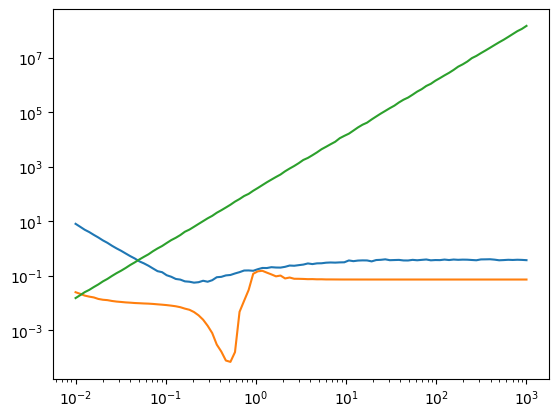

In [82]:
plt.plot(vars.detach().cpu(),socm_errs.detach().cpu())
plt.plot(vars.detach().cpu(),efc_errs.detach().cpu())
plt.plot(vars.detach().cpu(),norms.detach().cpu())

plt.yscale('log')
plt.xscale('log')

In [41]:
err = ((learned_control - target_control)**2).mean()
print(err)

tensor(0.1945, device='cuda:0', grad_fn=<MeanBackward0>)


## Testing

In [3]:
experiment_path

'experiments/OUQ_hard_T4_d20_repulsive'

In [4]:
efc_cfg = OmegaConf.load(experiment_path+f'/EFC_2/cfg.yaml')
socm_cfg = OmegaConf.load(experiment_path+f'/SOCM/cfg.yaml')

ts = torch.linspace(0, efc_cfg.method.T, efc_cfg.method.num_steps + 1).to(efc_cfg.method.device)

x0, sigma, optimal_sde, eigen_sde = define_variables_efc(efc_cfg, ts)
x0, sigma, optimal_sde, neural_sde, _ = define_variables_socm(socm_cfg, ts)

eigen_sde.eigvals

x0: tensor([ 0.2198, -0.2520,  0.0327,  0.2179, -0.0751,  0.7093, -0.6886, -0.1037,
        -0.8131, -0.0786, -0.0125, -0.4422, -0.1183,  0.1363,  0.8299, -0.5454,
         0.1774,  0.5601, -0.0707,  0.4247], device='cuda:0')
2
x0: tensor([-0.1114, -0.5969,  0.3957, -0.1157,  0.4218, -0.5161, -0.8573, -0.2978,
        -0.3315, -0.2889, -0.3449,  0.3854, -0.3700, -0.7866, -1.5009,  0.4227,
         0.1525,  0.4113, -1.4122, -0.0889], device='cuda:0')
initialize_models, self.use_stopping_time: False


tensor([0., 0.], device='cuda:0')

In [5]:
combined_sde = CombinedSDE(neural_sde, eigen_sde)

In [ ]:
if optimal_sde is not None:
    ground_truth_control = optimal_sde.u
else:
    ground_truth_control = None
    
batch_size = 128
state0 = x0.repeat(batch_size, 1)

neural_sde.use_learned_control = False
neural_sde.u = ground_truth_control
states,_,_,_,_,_,_,_, = stochastic_trajectories(
                        neural_sde,
                        state0,
                        ts.to(state0),
                        efc_cfg.method.lmbd,
                        detach=True
                        )

neural_sde.use_learned_control = True

target_control = ground_truth_control(ts, states, t_is_tensor=True)

In [7]:
combined_sde.eigen_sde.initialize_models()
combined_sde.initialize_models()

2
initialize_models, self.use_stopping_time: False


In [8]:
combined_sde.use_learned_control = True
combined_sde.sigma = combined_sde.neural_sde.sigma

In [9]:
states.shape

torch.Size([201, 128, 20])

In [10]:
combined_sde.b(None,states[:,0,:])

tensor([[-0.1114, -0.5969,  0.3957,  ...,  0.4113, -1.4122, -0.0889],
        [-0.1502, -0.5157,  0.4274,  ...,  0.2556, -1.2829, -0.2344],
        [-0.2593, -0.3966,  0.1842,  ...,  0.1265, -1.2247, -0.3734],
        ...,
        [-0.5000,  0.0316, -0.3374,  ..., -1.6228, -0.0577, -0.3104],
        [-0.6082,  0.1932, -0.4284,  ..., -1.7828, -0.1851, -0.3396],
        [-0.5265,  0.5316, -0.5468,  ..., -1.8559, -0.3621, -0.6203]],
       device='cuda:0')

In [11]:
states[:,0,:].shape

torch.Size([201, 20])

In [17]:
combined_sde.control(ts,states[:,0,:]).shape

torch.Size([201, 20])


torch.Size([201, 20])

In [9]:
def model_fn(x):
    out = combined_sde.neural_sde.model(x)[0]
    return out, out

model_jac = torch.vmap(torch.func.jacrev(model_fn,has_aux=True))

In [19]:
tx = torch.zeros((states.shape[0],states.shape[1],states.shape[2]+1),device=states.device)
tx[:,:,1:] = states
model_jac(tx[:,0,:])[0].shape

torch.Size([201, 21])